In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [168]:
BASE_DATA_FOLDER = "/content"
TRAIN_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "/content/drive/MyDrive/t_sne/cercospora")

In [169]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [170]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(15,15), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [171]:
def visualize_scatter(data_2d, label_ids, figsize=(15,15)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [172]:
images = []
labels = []

for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (150, 150))
        image = segment_plant(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

In [173]:
images.size

810000

In [174]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [175]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [136]:
import cv2
img = cv2.imread('/content/drive/MyDrive/t_sne/cercospora/real image/1.jpg',0)
print(img.shape)
#cv2.waitKey(0) 

(256, 256)


In [165]:
images.size

3857625

In [138]:
#images = np.reshape(images, (1, images.size))  ##Not to run

In [176]:
print(images.shape)

(400, 2025)


In [177]:
images

array([[  0,   0,   0, ..., 155, 156, 162],
       [110, 113, 113, ...,  18,  17,   0],
       [113, 139, 136, ...,  95, 102,  91],
       ...,
       [112, 101, 109, ...,  95,  90,  88],
       [ 99, 103, 103, ...,  92,  90,  90],
       [132, 137, 145, ..., 156, 155, 153]], dtype=uint8)

In [178]:
images_scaled = StandardScaler().fit_transform(images)

In [179]:
images_scaled.shape

(400, 2025)

In [180]:
label_ids.shape

(400,)

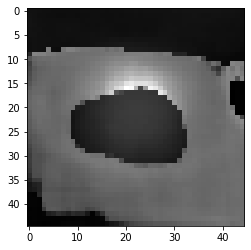

In [181]:
plt.imshow(np.reshape(images_scaled[0], (45,45)), cmap="gray")

# PCA

In [183]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(images_scaled)

In [184]:
pca_result.shape

(400, 2)

# t-SNE after PCA

In [189]:
tsne = TSNE(n_components=2, perplexity=50.0)

In [190]:
tsne_result = tsne.fit_transform(pca_result)

In [191]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

<Figure size 504x504 with 0 Axes>

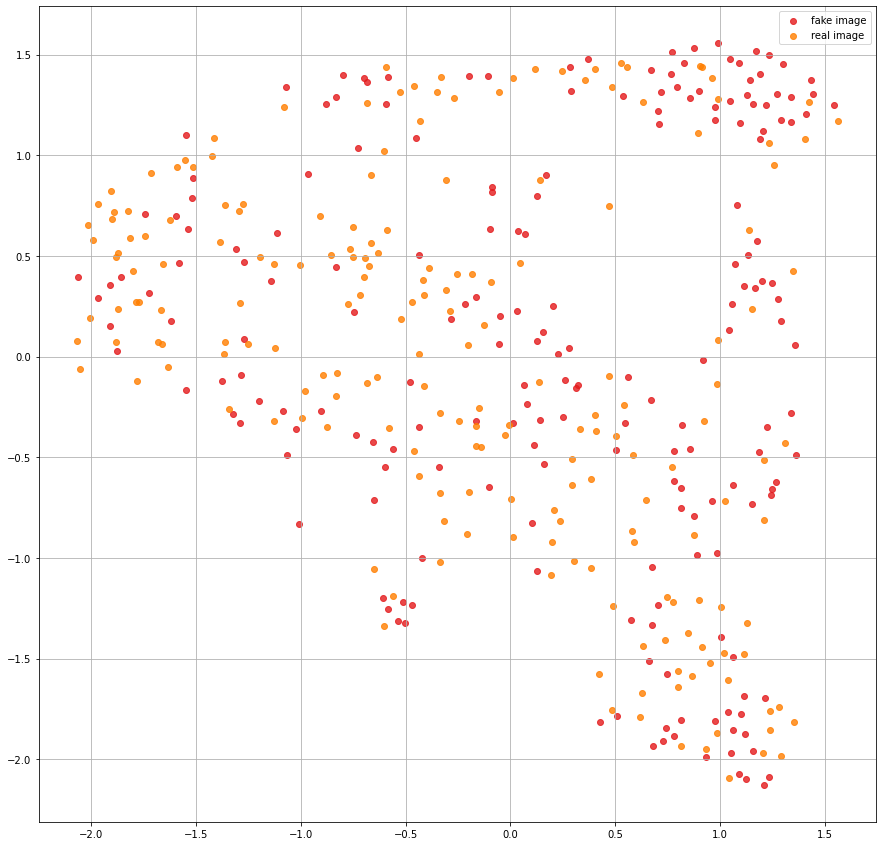

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))

visualize_scatter(tsne_result_scaled, label_ids)

In [ ]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)